## Introduction

This notebook evaluates the TimesFM model with ambient dataset for benchmarking purpose

Github: https://github.com/google-research/timesfm

arxiv: https://arxiv.org/abs/2310.10688

Frequency definitions

0: T, MIN, H, D, B, U

1: W, M

2: Q, Y

In [1]:
from typing import Optional, Tuple
from os import path
import numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader
from dataloader.dataloader import UnivariateMethaneHourly

from finetuning.finetuning_torch import FinetuningConfig, TimesFMFinetuner
from huggingface_hub import snapshot_download

from timesfm import TimesFm, TimesFmCheckpoint, TimesFmHparams
from timesfm.pytorch_patched_decoder import PatchedTimeSeriesDecoder
import plotly.graph_objects as go
import argparse

torch.cuda.is_available()

 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0].


True

In [2]:
data_dir = '/home/ran/Desktop/PycharmProjects/TimeSeries_Benchmarking/datasets/select'
data_file = 'Janvier.csv'

parser = argparse.ArgumentParser()
parser.add_argument('--data_dir', type=str, default=data_dir)
parser.add_argument('--data_file', type=str, default=data_file)
# TimesFM configurations
parser.add_argument('--timesfm', type=bool, default=True)
parser.add_argument('--freq_type', type=int, default=0)

parser.add_argument('--seq_len', type=int, default=512)
parser.add_argument('--pred_len', type=int, default=128)
# Optimization Hyperparams
parser.add_argument('--batch_size', type=int, default=32)
parser.add_argument('--epochs', type=int, default=100)
parser.add_argument('--learning_rate', type=float, default=1e-4)

args = parser.parse_args('')

In [3]:
repo_id = "google/timesfm-2.0-500m-pytorch"

hparams = TimesFmHparams(
    backend='gpu',
    per_core_batch_size=32,
    num_layers=50,
    horizon_len=args.pred_len,
    context_len=args.seq_len,
    use_positional_embedding=False,
    output_patch_len=128
)

tfm = TimesFm(
    hparams=hparams,
    checkpoint=TimesFmCheckpoint(
        huggingface_repo_id=repo_id
    )
)

model = PatchedTimeSeriesDecoder(tfm._model_config)

# checkpoint_path = path.join(snapshot_download(repo_id), 'torch_model.ckpt')
# loaded_checkpoint = torch.load(checkpoint_path, weights_only=True)
# model.load_state_dict(loaded_checkpoint)

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

In [4]:
config = FinetuningConfig(
    batch_size=args.batch_size,
    num_epochs=args.epochs,
    learning_rate=args.learning_rate,
    freq_type=args.freq_type,
    log_every_n_steps=10,
    val_check_interval=0.2,
    use_quantile_loss=True,
    use_wandb=False
)

# train_dataset = UnivariateMethaneHourly(args, flag='train')
# val_dataset = UnivariateMethaneHourly(args, flag='val')

100%|██████████| 4407/4407 [00:00<00:00, 212326.52it/s]


Processing dataframe with single process.
Finished preprocessing dataframe.
Finished forecasting.


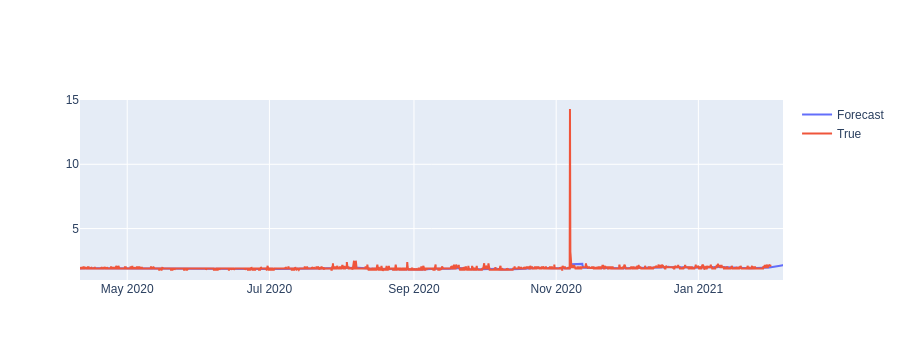

In [6]:
raw_df = pd.read_csv(str(path.join(data_dir, data_file)), parse_dates=True)
raw_df.reset_index(inplace=True)

test_df = raw_df[int(len(raw_df) * 0.8):]
test_df.columns = ['unique_id', 'ds', 'values']

test_df['ds'] = pd.to_datetime(test_df['ds'])

forecast_df = tfm.forecast_on_df(
    inputs=test_df,
    freq='1H'
)

forecast_df = forecast_df[['ds', 'timesfm']]
forecast_df = forecast_df.groupby(['ds']).mean()
forecast_df.reset_index(inplace=True)

fig = go.Figure()

fig.add_trace(go.Scatter(x=forecast_df['ds'], y=forecast_df['timesfm'], mode='lines', name='Forecast'))
fig.add_trace(go.Scatter(x=test_df['ds'], y=test_df['values'], mode='lines', name='True'))

fig.show()

# fig.write_html("./timesfm.html")